# KKBOX Feature Engineering
In this notebook, we will run feature extraction and selection using the `FeatureExtraction` class and automated modelling pipeline from `FeatureSelection.py` on the KKBOX dataset. KKBOX is a music subscription service that serves as a good example of how we can use the automated modelling pipeline to help model churn. 

For our purposes we randomly subsampled 1,000 users from the dataset. The methodology to create the cutoff times was replicated from the Featuretools customer churn demo, which can be found here: https://github.com/Featuretools/predict-customer-churn/tree/master/churn

In [2]:
import pandas as pd 
import numpy as np
import featuretools as ft
import featuretools.variable_types as vtypes
from featuretools.variable_types import Datetime, Timedelta, Variable
from FeatureExtraction import FeatureExtraction

## Importing Datasets

KKBOX has 4 main tables:
* `members` contains information on each member such as gender, city, and first registration time
* `trans` contains the transactional data of each member including transaction date and membership expiry date
* `logs` refers to the user log information for each member on specific dates such as the number of songs listened to for 25% of the song length, 100% of the song length, number of unique songs listened to, etc.
* `cutoff_times` refers to the cutoff date for extracting features. Since customers can churn multiple times in their customer lifecycle, each user id can have multiple cutoff dates.

In [3]:
members = pd.read_csv('members_v3_1k.csv', 
                      parse_dates=['registration_init_time'], 
                      infer_datetime_format = True, 
                      dtype = {'gender': 'category'})

trans = pd.read_csv('transactions_1k.csv',
                   parse_dates=['transaction_date', 'membership_expire_date'], 
                    infer_datetime_format = True)
# Filter only rows that are valid from transactions
trans = trans[trans['membership_expire_date'] > trans['transaction_date']]

logs = pd.read_csv('user_logs_1k.csv', parse_dates = ['date'])

cutoff_times = pd.read_csv('label_times.csv', parse_dates = ['cutoff_time'])
# Removing duplicates from cutoff table
cutoff_times = cutoff_times.drop_duplicates(subset = ['msno', 'cutoff_time'])

## Creating Featuretools `EntitySets`

The FeatureExtraction class is dependent on creating `EntitySets` and defining their relationships as per Featuretools documentation. Thus, we create `entities` for `trans`, `members`, and `logs`, with `members` being the parent table and `logs` and `trans` its children.

In [4]:
# Make empty entityset
es = ft.EntitySet(id = 'customers')

# Create entity from transactions
es.entity_from_dataframe(entity_id='transactions', dataframe=trans,
                         index = 'transactions_index', make_index = True,
                         time_index = 'transaction_date', 
                         variable_types = {'payment_method_id': vtypes.Categorical, 
                                           'is_auto_renew': vtypes.Boolean, 'is_cancel': vtypes.Boolean})
# Create entity from members
es.entity_from_dataframe(entity_id='members', dataframe=members,
                         index = 'msno', time_index = 'registration_init_time', 
                         variable_types = {'city': vtypes.Categorical, 
                                           'registered_via': vtypes.Categorical})
#Create entity from user logs
es.entity_from_dataframe(entity_id='logs', dataframe=logs,
                         index = 'logs_index', make_index = True,
                         time_index = 'date')

# Relationships (parent, child)
r_member_transactions = ft.Relationship(es['members']['msno'], es['transactions']['msno'])
r_member_logs = ft.Relationship(es['members']['msno'], es['logs']['msno'])

es.add_relationships([r_member_transactions, r_member_logs])



Entityset: customers
  Entities:
    transactions [Rows: 16351, Columns: 10]
    members [Rows: 882, Columns: 6]
    logs [Rows: 252022, Columns: 10]
  Relationships:
    transactions.msno -> members.msno
    logs.msno -> members.msno

## Feature Extraction

Now that we have set up the `EntitySet` we can run the FeatureExtraction class. The `target_entity` is the `members` entity as we want to perform the aggregate functions on the `logs` and `trans` features and transform functions on `members`. We will also use a `training_window` of 3 and 6 months (`time_scope = 'monthly'`). Furthermore, we will create features using a `max_depth` of 3, meaning that we will create features _on top_ of the created features. The feature matrix generated will comprise of features that were built using data before the cutoff time as well as 3 and 6 months from the cutoff time.   

In [5]:
# Specify aggregation primitives
agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 
                  'mean', 'percent_true', 'max', 'std', 'count']
# Specify transformation primitives
trans_primitives = ['weekend', 'cum_sum', 'day', 'month', 'diff', 'time_since_previous']

In [6]:
from timeit import default_timer as timer

start = timer()

kkbox_mo = FeatureExtraction(es)
kkbox_mo.add_agg_primitives(agg_primitives)
kkbox_mo.add_trans_primitives(trans_primitives)
training_window = [3,6]
kkbox_mo.dfsWindow('members', 'monthly', training_window, cutoff_times, max_depth=3, chunk_size=1000)

end = timer()
print('%f seconds elapsed.'%round(end - start)) 

The aggregate primitives have been added:  sum time_since_last avg_time_between all mode num_unique min last mean percent_true max std count
weekend is not in the available transform primitives.
The transformative primitives have been added:  cum_sum day month diff time_since_previous
Built 301 features
Elapsed: 02:34 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 22/22 chunks
2019-04-19 04:58:19,133 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:19,140 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:19,161 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:19,166 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:19,173 featuretools.entityset - WARNING    Using training_window

2019-04-19 04:58:29,383 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:29,392 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:29,410 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:29,415 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:29,422 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:29,441 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:30,519 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:30,527 featuretools.entityset - WARNING    Using training_wind

2019-04-19 04:58:41,250 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:41,257 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:41,277 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:42,128 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:42,135 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:42,157 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:42,162 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:42,170 featuretools.entityset - WARNING    Using training_wind

2019-04-19 04:58:53,049 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:53,056 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:53,086 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:53,092 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:53,099 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:58:53,124 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:58:54,395 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:58:54,402 featuretools.entityset - WARNING    Using training_wind

2019-04-19 04:59:08,094 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:08,102 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:59:08,123 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:59:09,515 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:09,522 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:59:09,545 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:59:09,550 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:09,557 featuretools.entityset - WARNING    Using training_wind

2019-04-19 04:59:19,500 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:19,507 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:59:19,528 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:59:19,534 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:19,541 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity transactions
2019-04-19 04:59:19,564 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity logs
2019-04-19 04:59:20,452 featuretools.entityset - WARNING    Using training_window but last_time_index is not set on entity members
2019-04-19 04:59:20,460 featuretools.entityset - WARNING    Using training_wind

In [7]:
print("Number of features in kkbox_mo: ", len(kkbox_mo.feature_defs))
kkbox_mo.feature_defs

Number of features in kkbox_mo:  834


['city',
 'gender',
 'bd',
 'registered_via',
 'MEAN(transactions.actual_amount_paid)',
 'LAST(logs.num_unq)',
 'AVG_TIME_BETWEEN(logs.date)',
 'MIN(logs.num_75)',
 'SUM(logs.total_secs)',
 'AVG_TIME_BETWEEN(transactions.transaction_date)',
 'MIN(logs.num_50)',
 'MIN(logs.total_secs)',
 'SUM(logs.num_unq)',
 'MONTH(registration_init_time)',
 'LAST(logs.num_50)',
 'PERCENT_TRUE(transactions.is_auto_renew)',
 'LAST(transactions.plan_list_price)',
 'MIN(transactions.plan_list_price)',
 'STD(transactions.plan_list_price)',
 'MEAN(logs.num_unq)',
 'LAST(transactions.is_auto_renew)',
 'MAX(logs.num_100)',
 'LAST(logs.total_secs)',
 'STD(logs.num_25)',
 'COUNT(logs)',
 'MEAN(logs.total_secs)',
 'SUM(transactions.plan_list_price)',
 'LAST(logs.num_25)',
 'MEAN(logs.num_25)',
 'ALL(transactions.is_auto_renew)',
 'MAX(logs.num_75)',
 'LAST(logs.num_75)',
 'MAX(logs.total_secs)',
 'STD(logs.total_secs)',
 'MAX(logs.num_25)',
 'SUM(transactions.actual_amount_paid)',
 'NUM_UNIQUE(transactions.payme

In [8]:
kkbox_mo.df.head(5)

,,city,gender,bd,registered_via,MEAN(transactions.actual_amount_paid),LAST(logs.num_unq),AVG_TIME_BETWEEN(logs.date),MIN(logs.num_75),SUM(logs.total_secs),AVG_TIME_BETWEEN(transactions.transaction_date),...,CUM_SUM(MEAN(logs.CUM_SUM(num_100)))_6mos,CUM_SUM(MEAN(transactions.CUM_SUM(payment_plan_days)))_6mos,CUM_SUM(LAST(transactions.CUM_SUM(plan_list_price)))_6mos,CUM_SUM(MEAN(logs.CUM_SUM(num_50)))_6mos,CUM_SUM(MAX(logs.CUM_SUM(total_secs)))_6mos,CUM_SUM(STD(logs.CUM_SUM(num_unq)))_6mos,CUM_SUM(STD(transactions.CUM_SUM(actual_amount_paid)))_6mos,CUM_SUM(SUM(logs.CUM_SUM(total_secs)))_6mos,CUM_SUM(SUM(logs.CUM_SUM(num_985)))_6mos,CUM_SUM(SUM(logs.CUM_SUM(num_50)))_6mos
msno,time,,,,,,,,,,,,,,,,,,,,,
+6KodETinDioAsOrJjj1UH425xG3uM6N/bd49J15How=,2015-01-01,1.0,NaN,0.0,7.0,NaN,NaN,NaN,NaN,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+WiZkfIp5sDsf0xZvBnR2j6Kxi1u2k0t0mJBJqhQIJo=,2015-01-01,13.0,male,25.0,9.0,NaN,17.0,NaN,1.0,2106.478,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
+eELJ1gSSkwJItUOLgavd0hFy/TLj0RVrcaPgQunOPM=,2015-01-01,14.0,NaN,0.0,9.0,NaN,NaN,NaN,NaN,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1204794.71,140.0,262.0
+s3jJdEWKI0aVm/aTtJjbl1/6m9T+Fdshe1opAtZTy8=,2015-01-01,1.0,NaN,0.0,7.0,NaN,NaN,NaN,NaN,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/OrkK+agRQCMhB2GK3KctomRLGCQuWxUqw9ml1eQNog=,2015-01-01,11.0,male,22.0,9.0,NaN,NaN,NaN,NaN,0.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
kkbox_mo.df.shape

(18651, 834)

## Prepping the Data

Before running the kkbox_mo dataset through the automated modelling pipeline, human intervention will still be required to make sure the data is valid. We will drop rows with missing values in the `label` column, drop duplicates, keep our data to members whose birthdays are between 6 and 120, and fill in missing values with the mean.

In [10]:
fm = kkbox_mo.df.copy()
fm = fm.reset_index()
fm.drop(columns=["days_to_churn", "churn_date"], inplace=True)
fm = fm.dropna(subset=["label"])
fm = fm.drop_duplicates(subset = ['msno', 'time'])
fm = pd.get_dummies(fm.drop(columns=['time', 'msno']))
fm = fm[(fm.bd<120) & (fm.bd>6)]
fm = fm.fillna(fm.mean())

In [11]:
fm.shape

(7497, 838)

## Feature Selection with the Automated Modeling Pipeline

Now we will run the feature matrix through the pipeline. The pipeline applies functions in the order of its position in the pipeline. In this case, the order is:

1. DropMissing - columns with more than 70% missing values are dropped
2. DropDuplicate - duplicate columns are dropped
3. DropZeroCov - columns with zero variance are dropped (ie only have one value)
4. DropHighCorr - columns that have a correlation coefficient of 0.9 or more are dropped
5. RFSelector - features are ranked by importance using Random Forest and features that comprise 80% of total feature importance are kept

In [12]:
from sklearn.pipeline import Pipeline
from FeatureSelection import DropMissing, DropDuplicate, DropZeroCov, DropHighCorr, RFSelector

#Pipeline inputs can be repositioned depending on the user
RFPipeline = Pipeline([
    ('drop_missing', DropMissing(threshold=0.7)),
    ('drop_duplicate', DropDuplicate()),
    ('drop_zerocov', DropZeroCov()),
    ('drop_correlated', DropHighCorr(threshold=0.9)),
    ('RF_selector', RFSelector(num_feat=0.8))
])

#The same pipeline above is also callable through
from FeatureSelection import RFPipeline

In [13]:
X = fm.drop(columns=['label'])
y = fm['label']
kkbox_reduced = RFPipeline.fit_transform(X, y)

---> 0 columns dropped due to missing values: []
---> 2 columns dropped due to duplicate values:

---> 1 columns dropped due to zero variance:
 ['LAST(transactions.is_cancel)_3mos']
---> 561 columns dropped due to collinearity:
 ['LAST(transactions.plan_list_price)', 'MIN(transactions.plan_list_price)', 'MEAN(logs.num_25)', 'MAX(logs.total_secs)', 'SUM(transactions.actual_amount_paid)', 'COUNT(transactions)', 'LAST(transactions.actual_amount_paid)', 'MODE(transactions.payment_method_id)', 'MAX(transactions.plan_list_price)', 'STD(logs.num_100)', 'SUM(logs.num_75)', 'MIN(transactions.payment_plan_days)', 'STD(transactions.payment_plan_days)', 'MAX(transactions.payment_plan_days)', 'SUM(transactions.payment_plan_days)', 'MEAN(transactions.payment_plan_days)', 'MIN(transactions.actual_amount_paid)', 'MEAN(transactions.plan_list_price)', 'STD(transactions.actual_amount_paid)', 'LAST(transactions.payment_plan_days)', 'CUM_SUM(MEAN(logs.num_unq))', 'CUM_SUM(NUM_UNIQUE(transactions.payment_me

/home/sahil94/.local/lib/python3.5/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


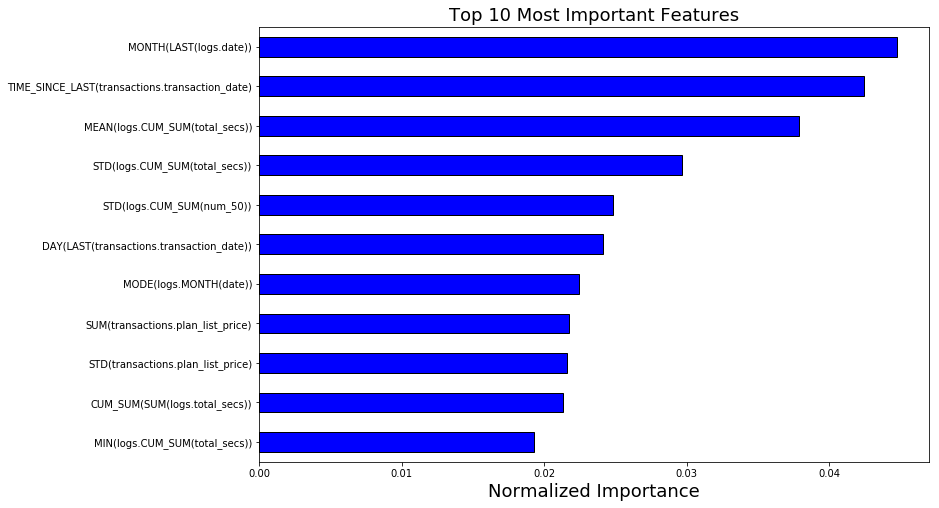

In [14]:
RFPipeline.named_steps["RF_selector"].plot_importance()

In [15]:
print("Shape of KKBOX dataset after feature extraction: ", kkbox_mo.df.shape)
print("Shape of KKBOX dataset after feature selection: ", kkbox_reduced.shape)
print("Number of features dropped: ", kkbox_mo.df.shape[1]-kkbox_reduced.shape[1])

Shape of KKBOX dataset after feature extraction:  (18651, 834)
Shape of KKBOX dataset after feature selection:  (7497, 57)
Number of features dropped:  777


## Modelling the Data with Light GBM

Now we will run the reduced KKBOX dataset through Light GBM

In [16]:
import lightgbm as lgb

RSEED = 40

def cross_validate(X, y):
    """Compute cross validation ROC AUC of a gradient boosting model for a given training dataset"""
    
    # Extract the labels
    train_labels = y
    train = X

    # Create a  lgb training set
    train_set = lgb.Dataset(train, label = train_labels)

    # Find default hyperparameters
    model = lgb.LGBMClassifier()
    params = model.get_params()

    # Number of estimators will be selected through early stopping
    del params['n_estimators'], params['silent']

    # Early stoppping with 5 fold cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                        early_stopping_rounds = 100, seed = RSEED, nfold = 5)

    print('Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                               cv_results['auc-stdv'][-1]))

    print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))
    
    return cv_results

In [17]:
cv_results_baseline = cross_validate(kkbox_reduced, y)

Cross Validation ROC AUC: 0.89829 with std: 0.02676.
Number of estimators trained: 49


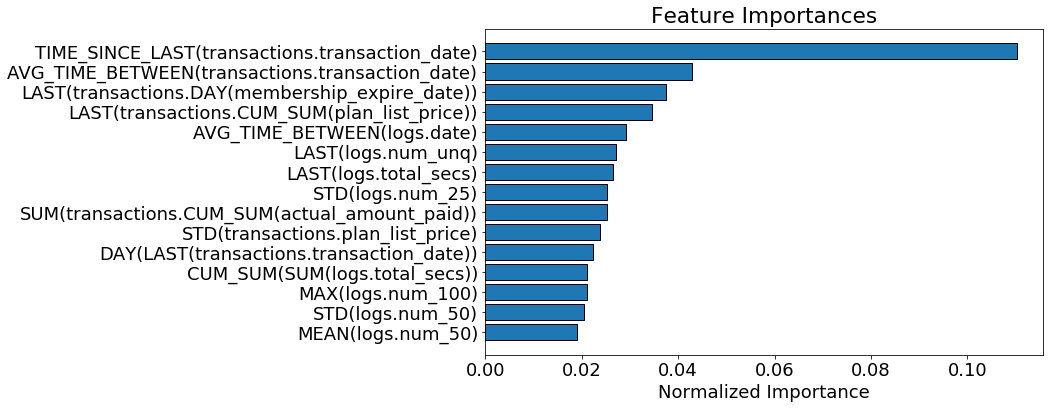

,index,feature,importance,importance_normalized,cumulative_importance
0,1,TIME_SINCE_LAST(transactions.transaction_date),162,0.110204,0.110204
1,53,AVG_TIME_BETWEEN(transactions.transaction_date),63,0.042857,0.153061
2,40,LAST(transactions.DAY(membership_expire_date)),55,0.037415,0.190476
3,11,LAST(transactions.CUM_SUM(plan_list_price)),51,0.034694,0.225170
4,27,AVG_TIME_BETWEEN(logs.date),43,0.029252,0.254422
5,23,LAST(logs.num_unq),40,0.027211,0.281633
6,44,LAST(logs.total_secs),39,0.026531,0.308163
7,19,STD(logs.num_25),37,0.025170,0.333333
8,47,SUM(transactions.CUM_SUM(actual_amount_paid)),37,0.025170,0.358503
9,8,STD(transactions.plan_list_price),35,0.023810,0.382313


In [18]:
## Feature Importance
X = kkbox_reduced

# New model fit on the training data
model = lgb.LGBMClassifier(n_estimators = len(cv_results_baseline['auc-mean']), random_state = RSEED)
model.fit(X, y)

# Put feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': list(X.columns), 
                                    'importance': model.feature_importances_})

import matplotlib.pyplot as plt

def plot_feature_importances(df):
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    
    return df
norm_fi = plot_feature_importances(feature_importances)
norm_fi.head(20)